# 👋 Welcome to the **CRAFT** Pytorch tutorial


In this tutorial, we will take a model, several images and run CRAFT to extract concepts and then display them using Concept Attribution Maps.

💡 In order to better understand what we are going to do, you may want to read the original paper before:
[Concept Recursive Activation Factorisation (CRAFT)](https://arxiv.org/pdf/2211.10154.pdf).

_Authors: [Thomas FEL](https://thomasfel.fr/), [Agustin PICARD](), [Louis Béthune](), [Thibaut Boissin]()_

# 1 - Loading the data and preparing the model

🛠 CRAFT requires splitting the model in two parts. So, we will prepare two functions $(g, h)$ such that $f(x) = (g \cdot h)(x)$. To put it simply, $g$ is the function that maps our input to the latent space (the penultimate layer of our model), and $h$ is the function that maps this penultimate layer to the output. It is important to note that if the model contains a global average pooling layer, it is strongly recommended to provide CRAFT with the layer before the global average pooling.

⚠️ Please keep in mind that the activations must be positives (after relu or any positive activation function)

In [1]:
!pip install -q craft-xai

In [3]:
import tensorflow as tf
import numpy as np

rabbit_class = 330 # imagenet class for rabbit

# loading some images of rabbits !
#images = np.load('assets/rabbit.npz')['arr_0']
images = np.load('rabbit.npz')['arr_0']
images_preprocessed = tf.keras.applications.densenet.preprocess_input(images)

images_preprocessed.shape

(300, 224, 224, 3)

In [4]:
model = tf.keras.applications.DenseNet121(classifier_activation="linear")

# cut the model in two parts (as explained in the paper)
# first part is g(.) our 'input_to_latent' model, second part is h(.) our 'latent_to_logit' model
g = tf.keras.Model(model.input, model.layers[-3].output)
h = tf.keras.Model(model.layers[-2].input, model.layers[-1].output)

33188688/33188688 [==============================] - 3s 0us/step


# 2- How to use CRAFT


The API of CRAFT is really simple. We have 2 hyperparameters to define. First, the number of concepts ($r$ in the original paper), 10 is enough when we study the penultimate layer for a class of ImageNet. We provide tips and metrics to choose this hyperparameter below.

The second hyperparameter is the `patch_size`, or the size of the patches used for the concept extraction. For image of $224$, we encourage you to stay between $64$ and $128$ (half of the image).

Let's start by instantiating CRAFT



In [5]:
from craft.craft_tf import Craft

craft = Craft(input_to_latent = g,
              latent_to_logit = h,
              number_of_concepts = 10,
              patch_size = 80,
              batch_size = 64)

# now we can start fit the concept using our rabbit images
# CRAFT will (1) create the patches, (2) find the concept
# and (3) return the crops (crops), the embedding of the crops (crops_u), and the concept bank (w)
crops, crops_u, w = craft.fit(images_preprocessed)

crops.shape, crops_u.shape, w.shape

(TensorShape([2700, 80, 80, 3]),
 TensorShape([2700, 10]),
 TensorShape([10, 1024]))

# 3- Estimating the concept importance

The second crucial step before starting our investigation is to understand which concepts matter. To do so, we use Sobol indices and we compute them using a really simple api!

In [6]:
importances = craft.estimate_importance(images_preprocessed, class_id=rabbit_class) # 330 is the rabbit class id in imagenet
images_u = craft.transform(images_preprocessed)

images_u.shape

TensorShape([300, 7, 7, 10])

4 - Results

Concept 0  has an importance value of  0.48699743
Concept 2  has an importance value of  0.117166
Concept 4  has an importance value of  0.051799033
Concept 6  has an importance value of  0.04080138
Concept 1  has an importance value of  0.011758736


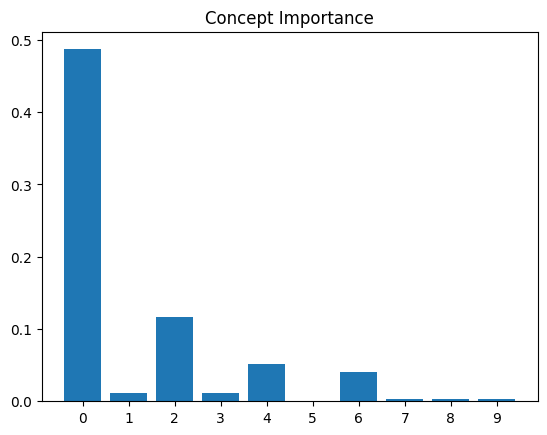

In [7]:
# We are done, let's inspect the results !
# first, lets see which concepts matter
import matplotlib.pyplot as plt

plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)))
plt.title("Concept Importance")

most_important_concepts = np.argsort(importances)[::-1][:5]

for c_id in most_important_concepts:
  print("Concept", c_id, " has an importance value of ", importances[c_id])

Concept 0  has an importance value of  0.48699743


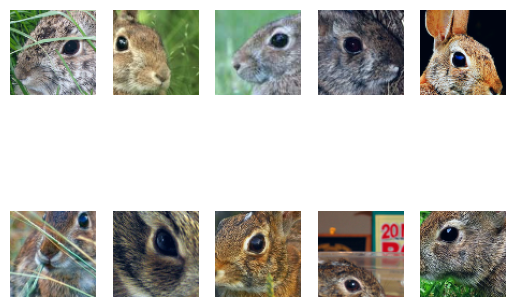




Concept 2  has an importance value of  0.117166


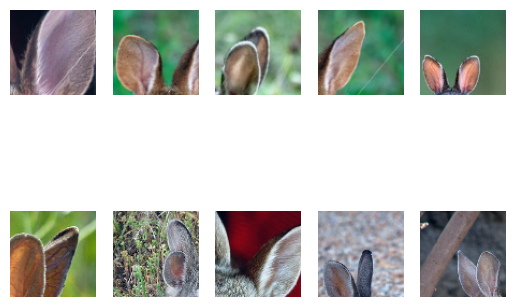




Concept 4  has an importance value of  0.051799033


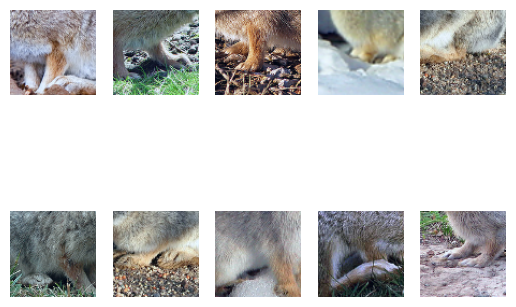




Concept 6  has an importance value of  0.04080138


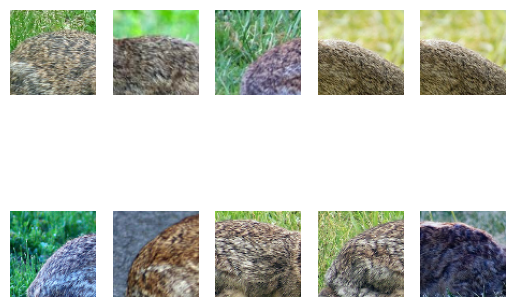




Concept 1  has an importance value of  0.011758736


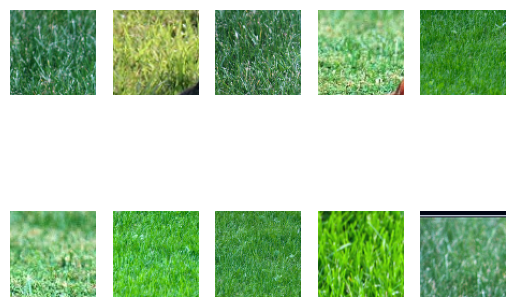

In [8]:
# Ok nice, let inspect those concepts by showing the 10 best crops for
# each concepts
from math import ceil
nb_crops = 10

def show(img):
  img = np.array(img)
  img -= img.min();img /= img.max()
  plt.imshow(img); plt.axis('off')

for c_id in most_important_concepts:

  best_crops_ids = np.argsort(crops_u[:, c_id])[::-1][:nb_crops]
  best_crops = np.array(crops)[best_crops_ids]

  print("Concept", c_id, " has an importance value of ", importances[c_id])
  for i in range(nb_crops):
    plt.subplot(ceil(nb_crops/5), 5, i+1)
    show(best_crops[i])
  plt.show()
  print('\n\n')

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib
import colorsys

def get_alpha_cmap(cmap):
  if isinstance(cmap, str):
    cmap = plt.get_cmap(cmap)
  else:
    c = np.array((cmap[0]/255.0, cmap[1]/255.0, cmap[2]/255.0))

    cmax = colorsys.rgb_to_hls(*c)
    cmax = np.array(cmax)
    cmax[-1] = 1.0

    cmax = np.clip(np.array(colorsys.hls_to_rgb(*cmax)), 0, 1)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [c,cmax])

  alpha_cmap = cmap(np.arange(256))
  alpha_cmap[:,-1] = np.linspace(0, 0.85, 256)
  alpha_cmap = ListedColormap(alpha_cmap)

  return alpha_cmap

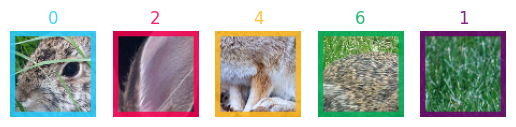

In [10]:
cmaps = [
  get_alpha_cmap((54, 197, 240)),
  get_alpha_cmap((210, 40, 95)),
  get_alpha_cmap((236, 178, 46)),
  get_alpha_cmap((15, 157, 88)),
  get_alpha_cmap((84, 25, 85))
]

def show(img, **kwargs):
  img = np.array(img)
  if img.shape[0] == 3:
    img = img.transpose(1, 2, 0)

  img -= img.min();img /= img.max()
  plt.imshow(img, **kwargs); plt.axis('off')


def plot_legend():
  for i, c_id in enumerate(most_important_concepts):
    cmap = cmaps[i]
    plt.subplot(1, len(most_important_concepts), i+1)

    best_crops_id = np.argsort(crops_u[:, c_id])[::-1][0]
    best_crop = crops[best_crops_id]

    p = 5
    mask = np.zeros(best_crop.shape[:-1])
    mask[:p, :] = 1.0
    mask[:, :p] = 1.0
    mask[-p:, :] = 1.0
    mask[:, -p:] = 1.0

    show(best_crop)
    show(mask, cmap=cmap)
    plt.title(f"{c_id}", color=cmap(1.0))

  plt.show()

plot_legend()

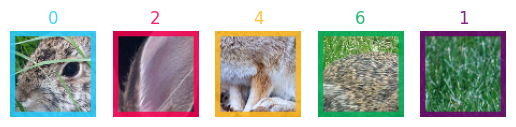

<ipython-input-10-098b6aa4d5e0>:14: RuntimeWarning: invalid value encountered in true_divide
  img -= img.min();img /= img.max()


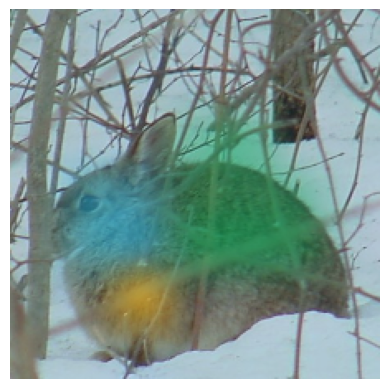

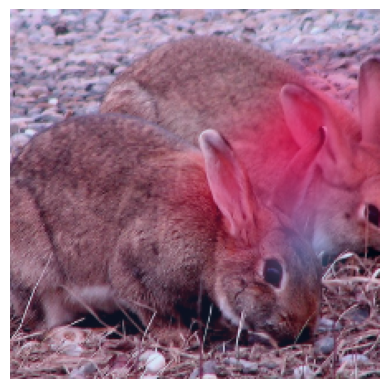

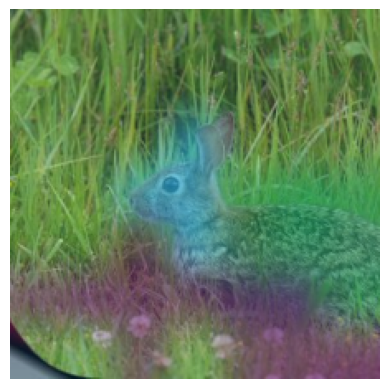

In [11]:
def concept_attribution_maps(id, percentile=95):
  img = images_preprocessed[id]
  u = images_u[id]

  show(img)

  for i, c_id in enumerate(most_important_concepts):

    cmap = cmaps[i]
    heatmap = u[:, :, c_id]

    # only show concept if excess N-th percentile
    sigma = np.percentile(np.array(images_u[:,:,:,c_id]).flatten(), percentile)
    heatmap = heatmap * np.array(heatmap > sigma, np.float32)

    heatmap = tf.image.resize(heatmap[:, :, None], (224, 224), method="bicubic")
    show(heatmap, cmap=cmap, alpha=0.7)

  plt.show()

plot_legend()
concept_attribution_maps(0)
plt.show()
concept_attribution_maps(1)
plt.show()
concept_attribution_maps(2)
plt.show()

# 5 Visualizing concept using MaCo !

MaCo is a recent paper (https://arxiv.org/abs/2306.06805) that unlock feature visualization for Deep Network.
The code is available in Xplique for Tensorflow and we can use it to visualize the concepts !

In [12]:
!pip install -q xplique

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 2.7 MB/s eta 0:00:00


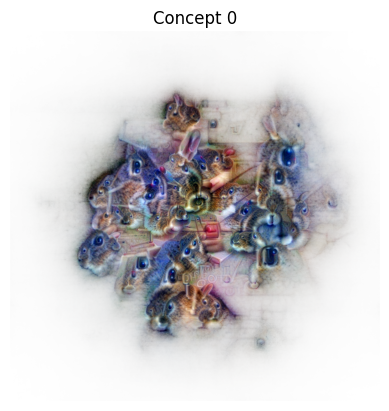

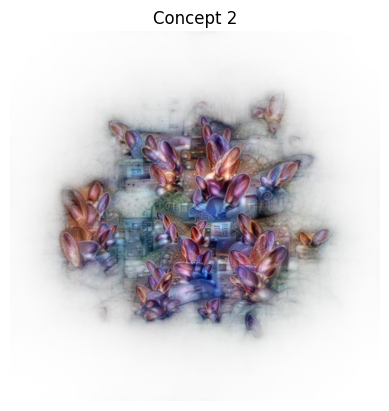

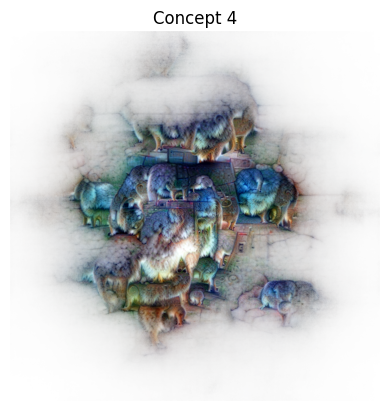

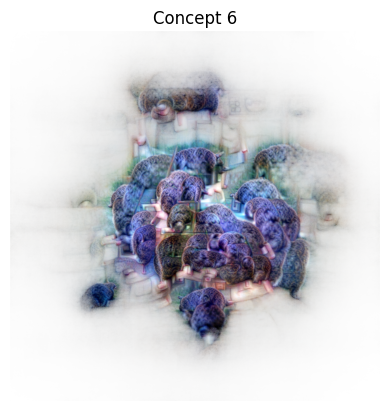

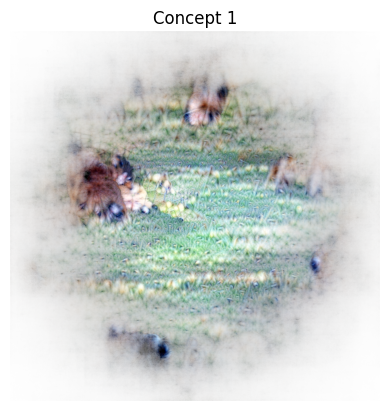

In [18]:
from xplique.features_visualizations import Objective, maco
from xplique.plots import  plot_maco

for concept_id in most_important_concepts:
  obj = Objective.direction(model, -2, w[concept_id])

  image, alpha = maco(obj, nb_steps=512, custom_shape=(1024, 1024))

  plot_maco(image, alpha)
  plt.title(f"Concept {concept_id}")
  plt.show()